In [2]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from datetime import timedelta, datetime
from tqdm import tqdm

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week
billboard_hot_100.head()

C:\Users\cutie\AppData\Local\Temp\ipykernel_13376\295147461.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week


,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year,week
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958,37
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958,37
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958,37
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958,37
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958,37


In [3]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

In [4]:
# Spotify creation date
spotify_creation_date = pd.to_datetime("2008-01-01", infer_datetime_format=True)

# Youtube creation date
youtube_creation_date = pd.to_datetime("2005-02-14", infer_datetime_format=True)

# Apple music creation date
apple_music_creation_date = pd.to_datetime("2015-06-30", infer_datetime_format=True)

# MTV Launch date
mtv_launch_date = pd.to_datetime("1981-08-01", infer_datetime_format=True)

# CDs creation date
cds_creation_date = pd.to_datetime("1982-08-17", infer_datetime_format=True)

# MP3 creation date
mp3_creation_date = pd.to_datetime("1991-12-01", infer_datetime_format=True)

# iTunes release date
itunes_creation_date = pd.to_datetime("2001-01-09", infer_datetime_format=True)

# Cassettes creation date
cassettes_creation_date = pd.to_datetime("1963-08-30", infer_datetime_format=True)

In [5]:
def get_era(date):
    if date < cassettes_creation_date:
        return "LPs and radio era"
    if date < mtv_launch_date:
        return "Cassettes era"
    if date < cds_creation_date:
        return "MTV era"
    if date < mp3_creation_date:
        return "CDs era"
    if date < itunes_creation_date:
        return "MP3 era"
    if date < youtube_creation_date:
        return "iTunes (early streaming) era"
    if date < spotify_creation_date:
        return "Youtube (streaming) era"
    if date < apple_music_creation_date:
        return "Spotify era"
    return "Late streaming era"
    
billboard_hot_100["era"] = billboard_hot_100["first_day_of_the_week"].apply(get_era)

## Eras distribution

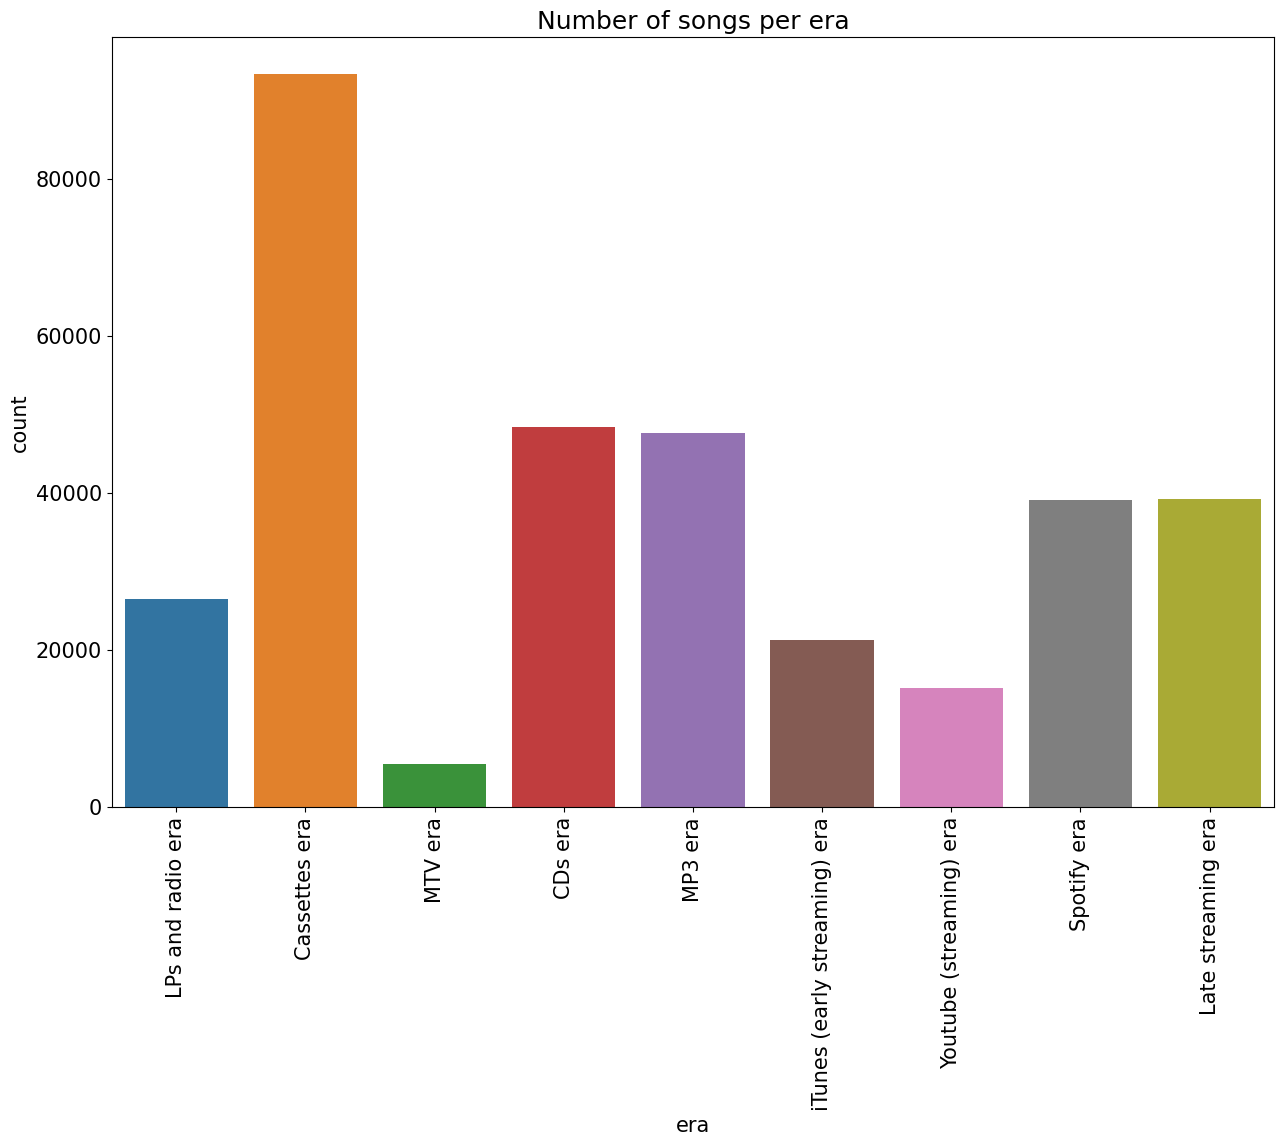

In [6]:
plt.figure(figsize=(15, 10))

sns.countplot(x="era", data=billboard_hot_100)
plt.xticks(rotation=90)
plt.title("Number of songs per era")
plt.show()

## Lifetime distribution

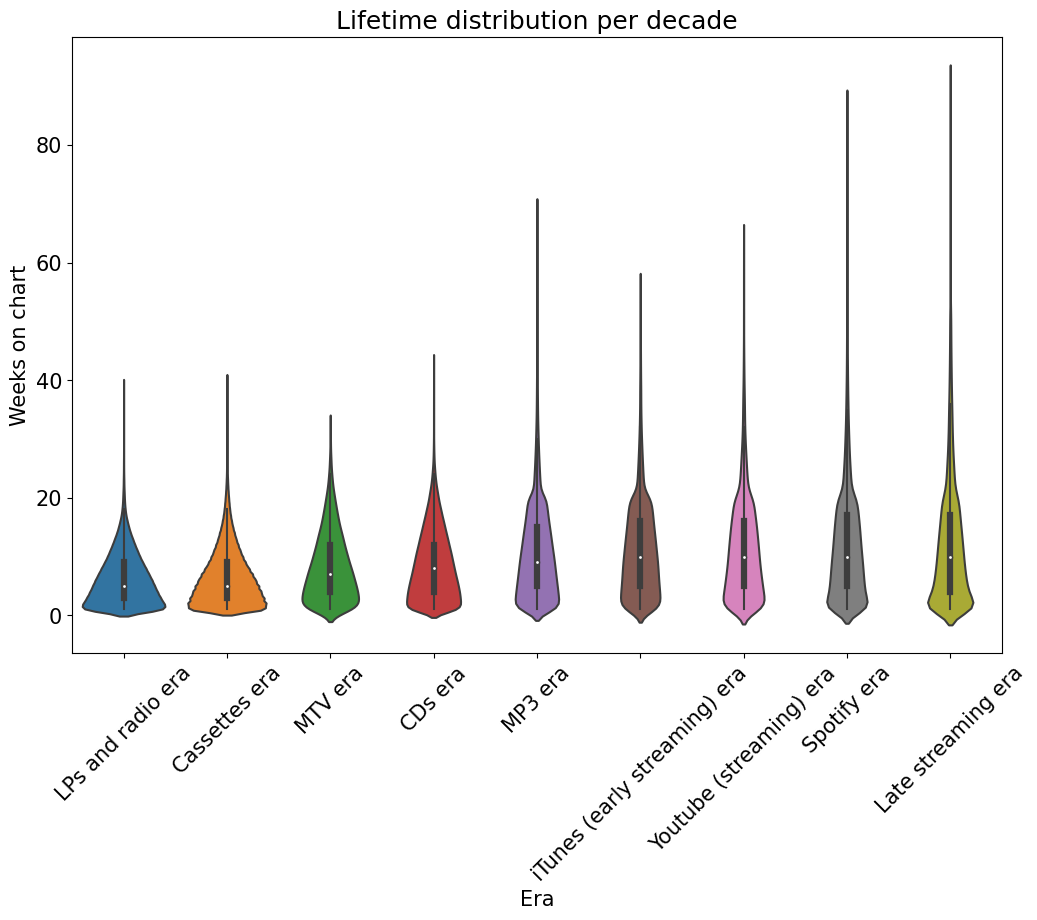

In [7]:
plt.figure(figsize=(12, 8))

sns.violinplot(x='era', y="weeks_on_chart", data=billboard_hot_100)

plt.title("Lifetime distribution per decade")
plt.xlabel("Era")
plt.ylabel("Weeks on chart")
plt.xticks(rotation=45)

#plt.savefig("figures/lifeftime_distribution_per_decade.pdf", format="pdf")
plt.show()

In [8]:
eras = billboard_hot_100["era"].unique()

In [9]:
eras_end_dates = {"LPs and radio era": cassettes_creation_date,
                "Cassettes era": mtv_launch_date,
                "MTV era": cds_creation_date,
                "CDs era": mp3_creation_date,
                "MP3 era": itunes_creation_date,
                "iTunes (early streaming) era": youtube_creation_date,
                "Youtube (streaming) era": spotify_creation_date,
                "Spotify era": apple_music_creation_date,
                "Late streaming era": datetime.now()}

## Position change

In [10]:
grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"],
                "era": row["era"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

In [11]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

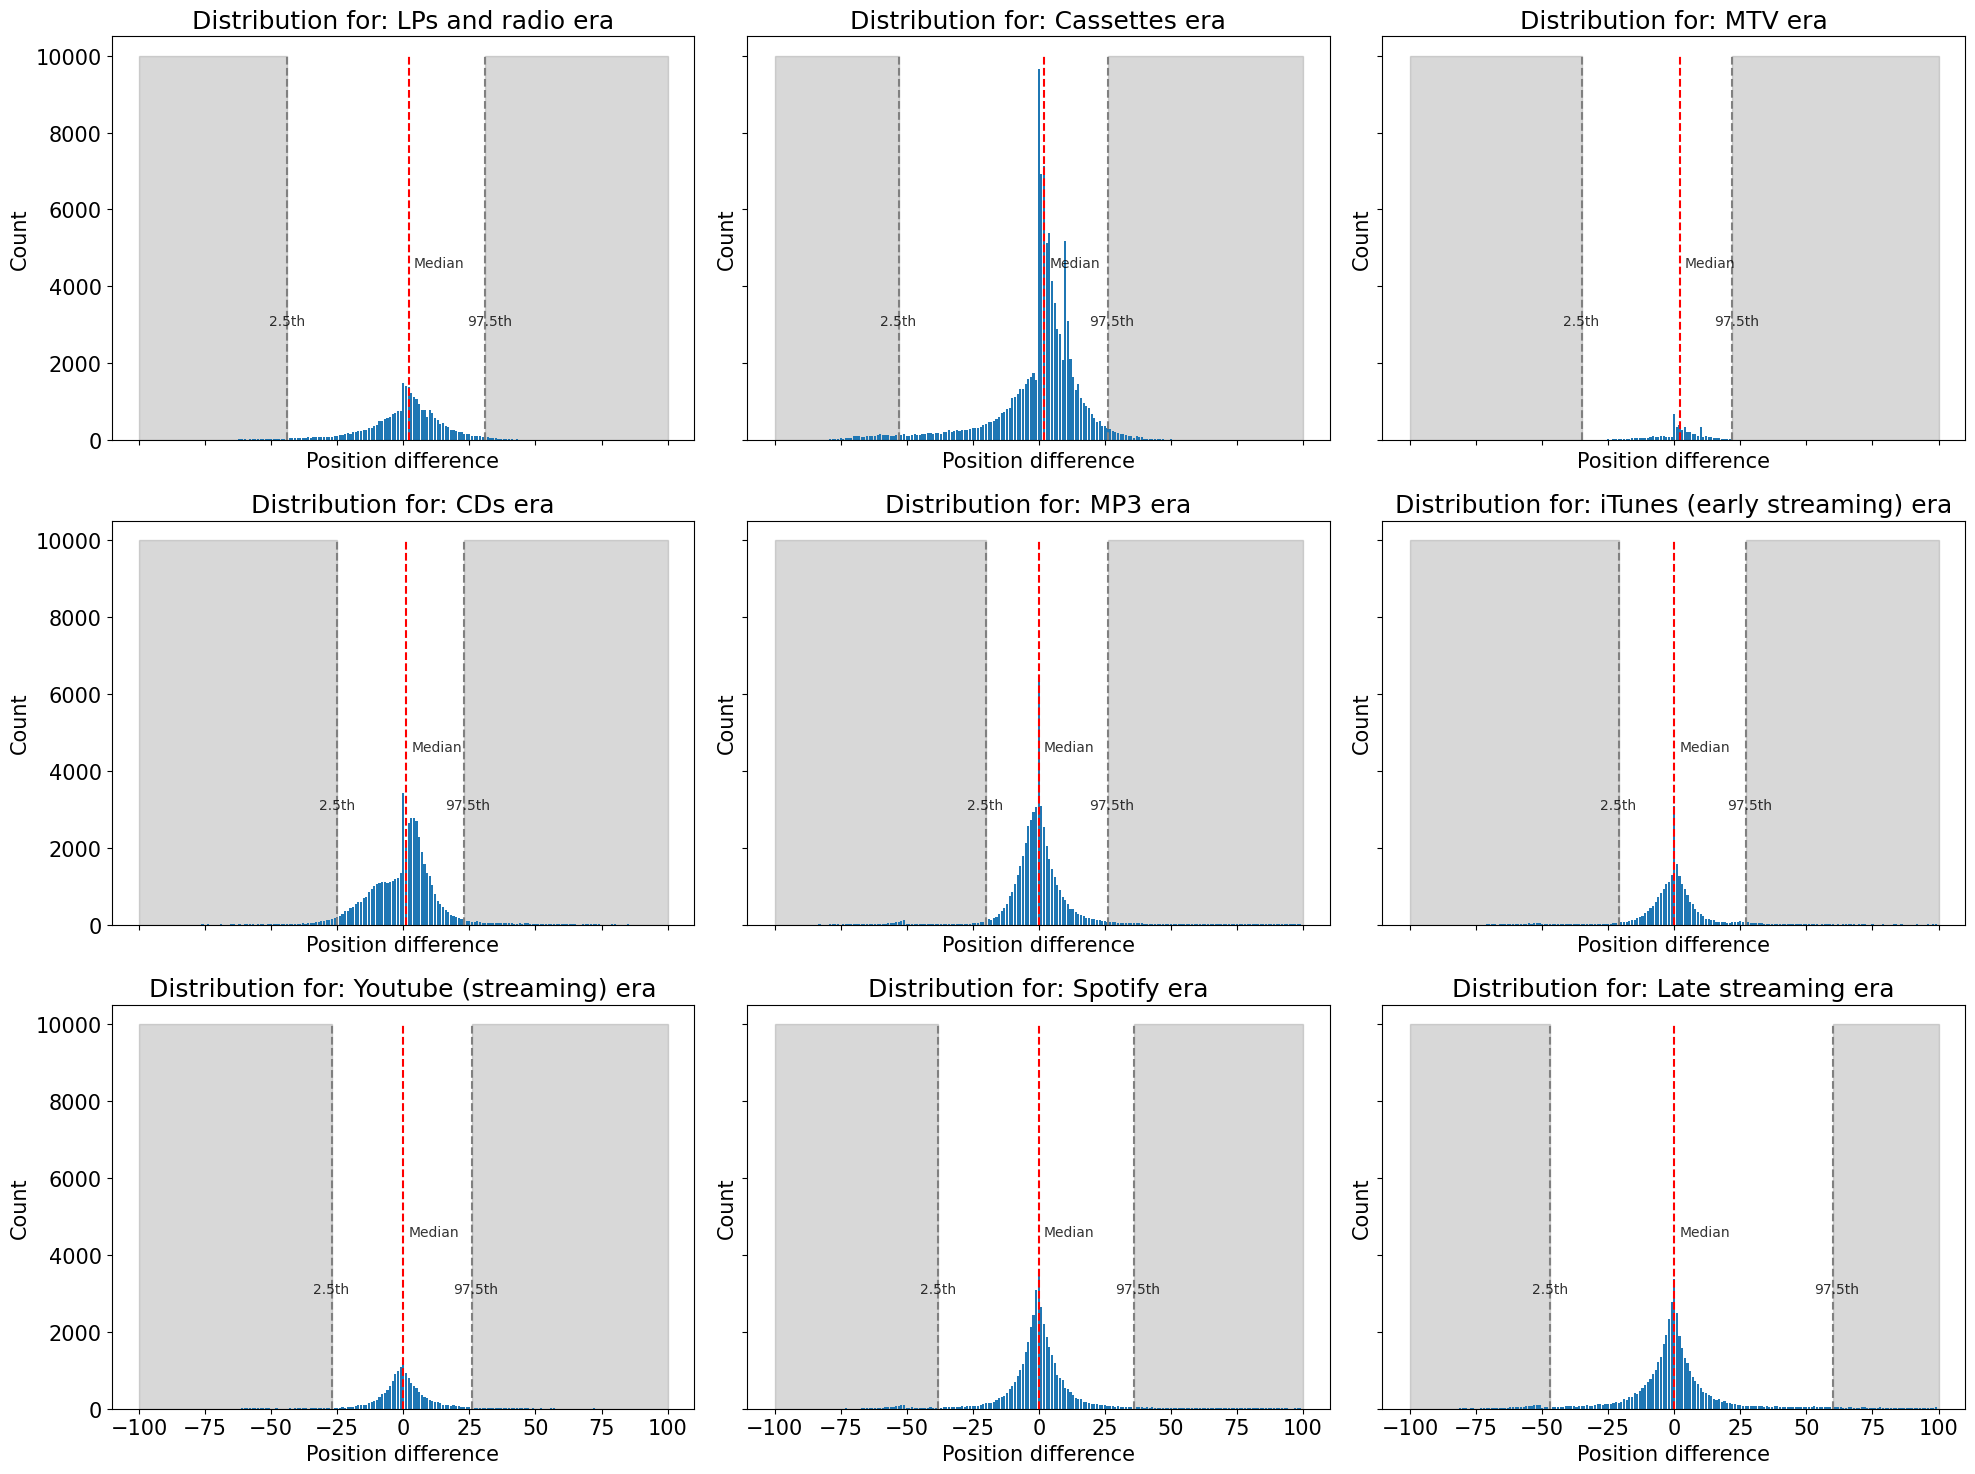

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = billboard_hot_100_with_disappeared_songs[["era", "first_day_of_the_week", "position_change"]]

for era in eras:
    decade_subset = billboard_subset[billboard_subset["era"] == era]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    perecentile_25 = decade_subset.quantile(0.025)
    perecentile_975 = decade_subset.quantile(0.975)
    perecentile_50 = decade_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=10000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=10000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=10000, color="red", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 10000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 7, 3000, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 10000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 7, 3000, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].text(perecentile_50 + 2, 4500, "Median", size = 10, alpha = 0.8)

    axes[row, col].bar(count_changes.index, count_changes.values)
    axes[row, col].set_title(f"Distribution for: {era}")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Count")
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    col += 1
    if col == 3:
        col = 0
        row += 1

plt.locator_params(axis='x', nbins=10)
fig.tight_layout()
#plt.savefig("figures/position_difference_distribution_decades.pdf", format="pdf")
plt.show()

In [13]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

billboard_hot_100["first_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

In [14]:
rows_to_add = []

for era in tqdm(eras):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[billboard_hot_100["era"] != era][["artist", "song_name"]]
    
    songs_in_decade = billboard_hot_100[(billboard_hot_100["era"] == era) & ~((billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"])))][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "year", "top_position", "first_week"]]
    grouped = songs_in_decade.groupby(["artist", "song_name"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < eras_end_dates[era]:
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"],
                        "era": era,
                        "first_week": row["first_week"]
                    })
                    week_date += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position", "era", "first_week"]], pd.DataFrame(rows_to_add)], ignore_index=True)

100%|██████████| 9/9 [05:14<00:00, 34.97s/it] 


100%|██████████| 9/9 [08:27<00:00, 56.34s/it] 


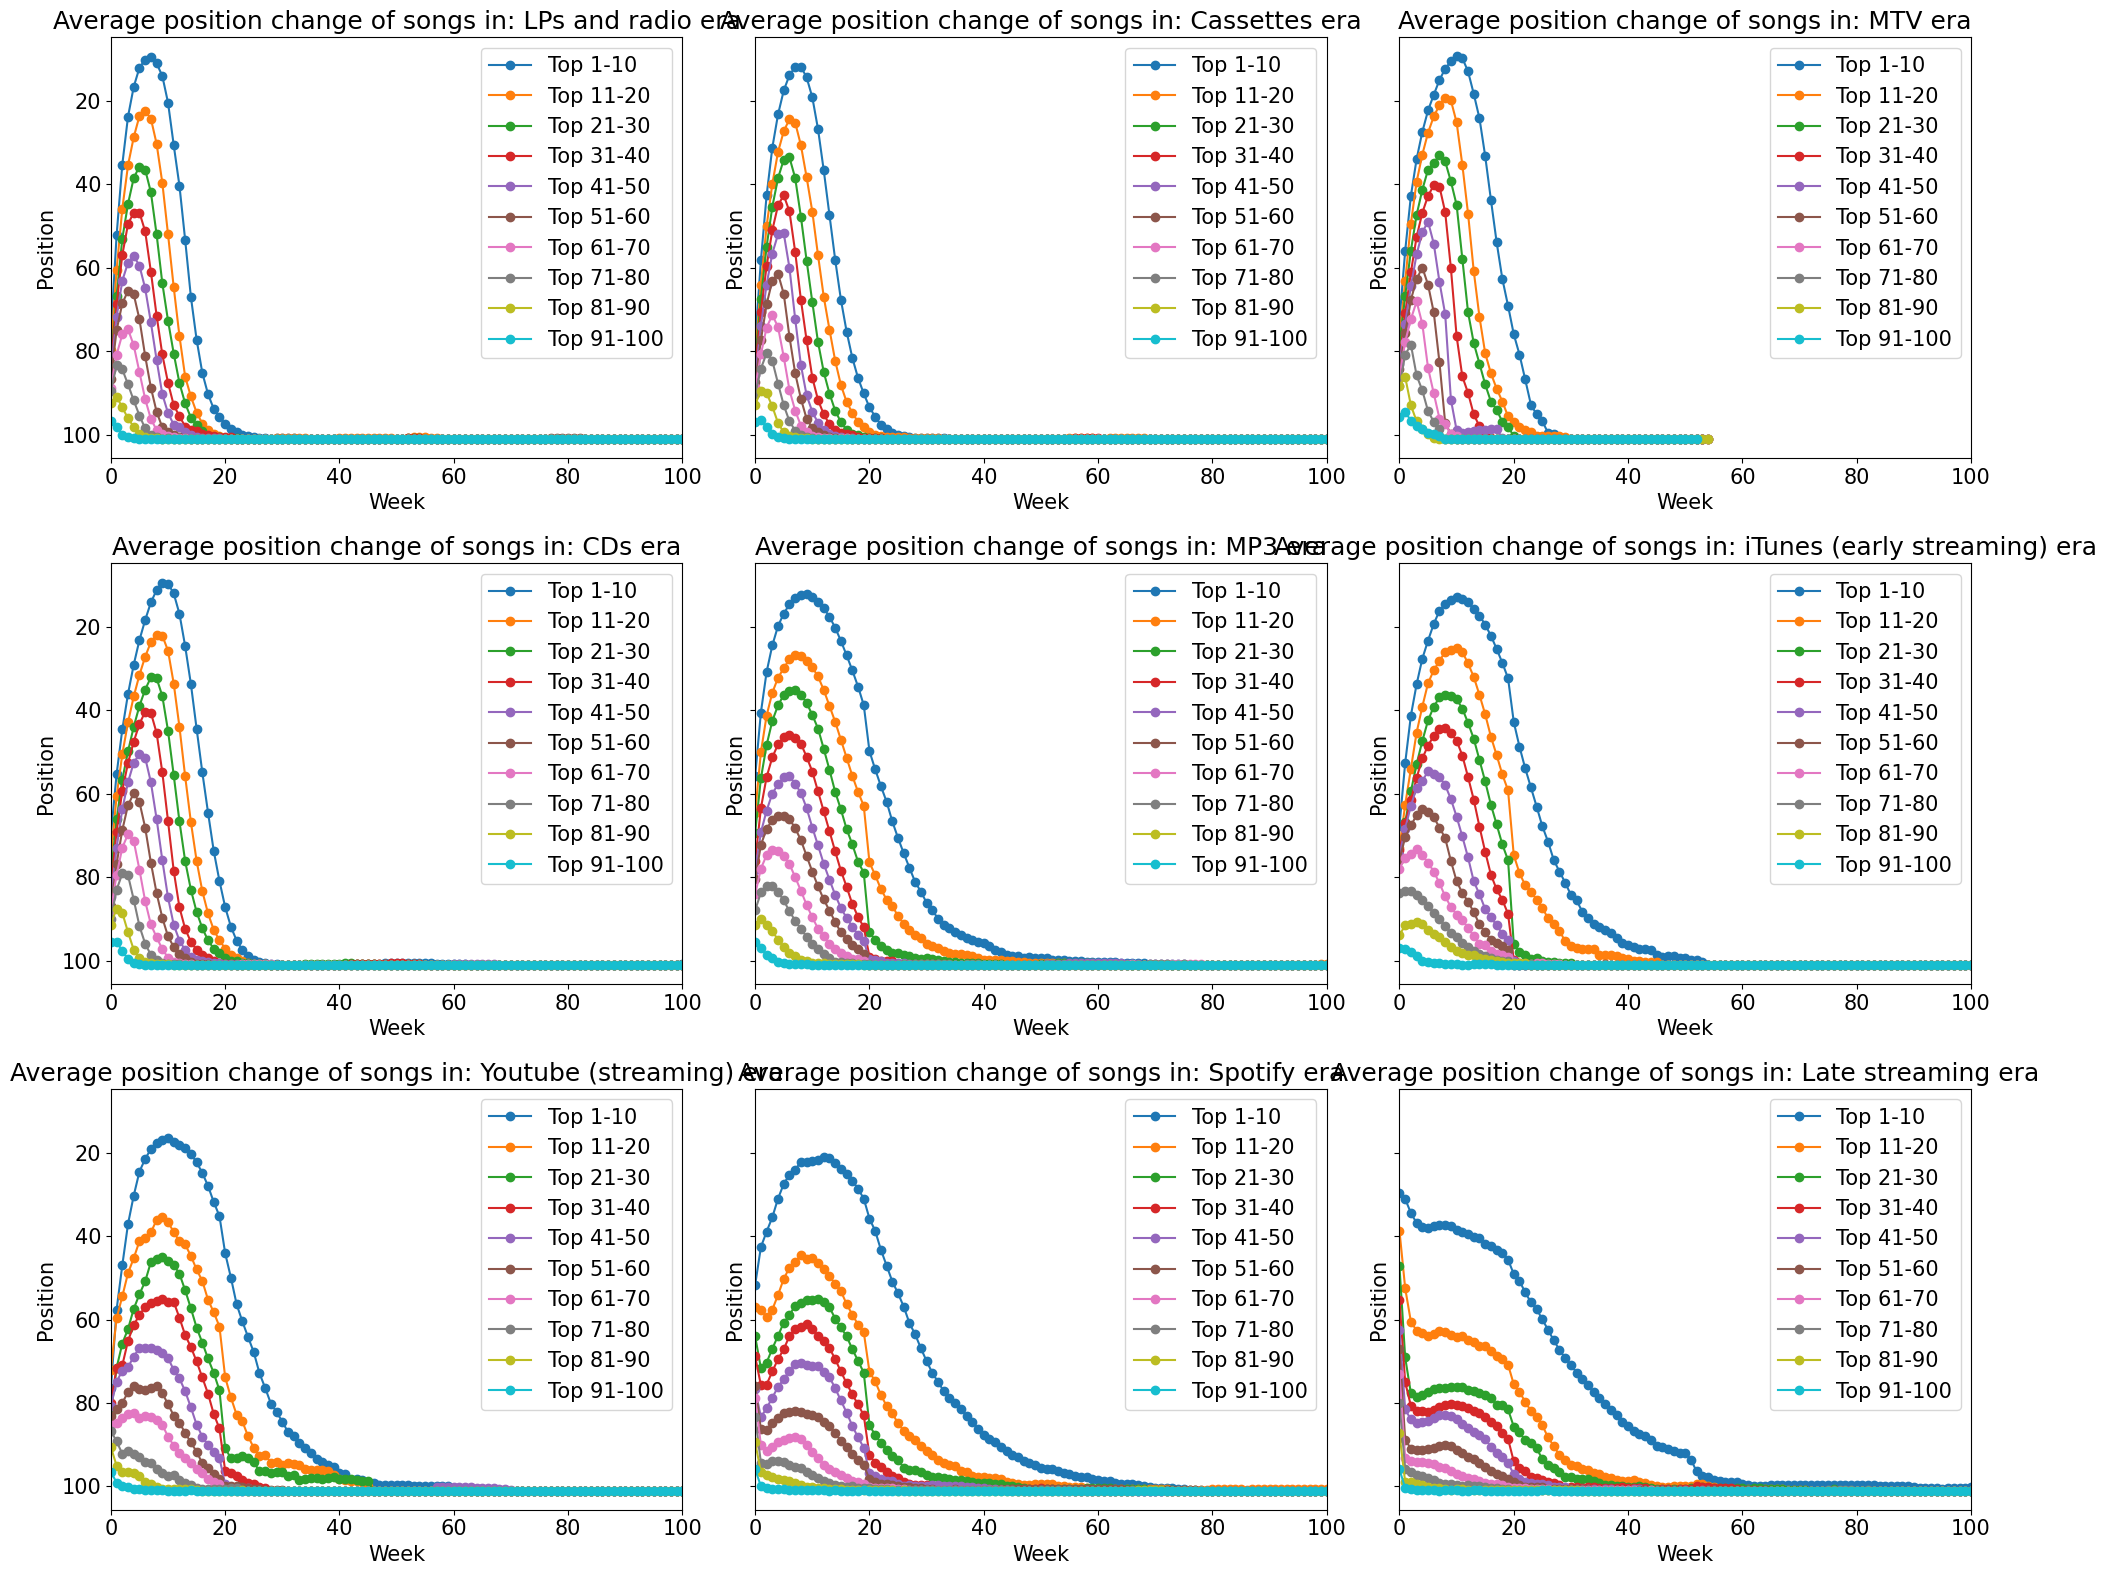

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for era in tqdm(eras):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks["era"] == era][["artist", "song_name", "first_day_of_the_week", "top_position", "position",
            "first_week", "era"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[billboard_hot_100["era"] != era][["artist", "song_name"]]

    for top_position in range(10, 110, 10):
        # songs that reached top 50 in the decade
        top_x_positions_in_decade = all_songs_in_decade[(all_songs_in_decade["top_position"] <= top_position) &\
            (all_songs_in_decade["top_position"] > top_position - 10)][["artist", "song_name"]]

        # take songs only from this decade
        top_x_positions_in_decade = top_x_positions_in_decade[~(top_x_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_x_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]

        # take all positions of the songs
        top_x_positions_in_decade = top_x_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist", "song_name",
                "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

        min_first_week = top_x_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

        top_x_positions_in_decade["first_day_of_the_week"] = top_x_positions_in_decade.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        top_x_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

        axes[row_i, col_i].plot(top_x_positions_in_decade.groupby("first_day_of_the_week")["position"].mean(),
            marker='o', label=f"Top {top_position - 9}-{top_position}")

    axes[row_i, col_i].set_title(f"Average position change of songs in: {era}")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim(0, 100)
    axes[row_i, col_i].legend()

    col_i += 1
    if col_i == 3:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
#plt.savefig("figures/average_position_change_per_top_position_decades.pdf", format="pdf")
plt.show()

100%|██████████| 9/9 [03:13<00:00, 21.51s/it]


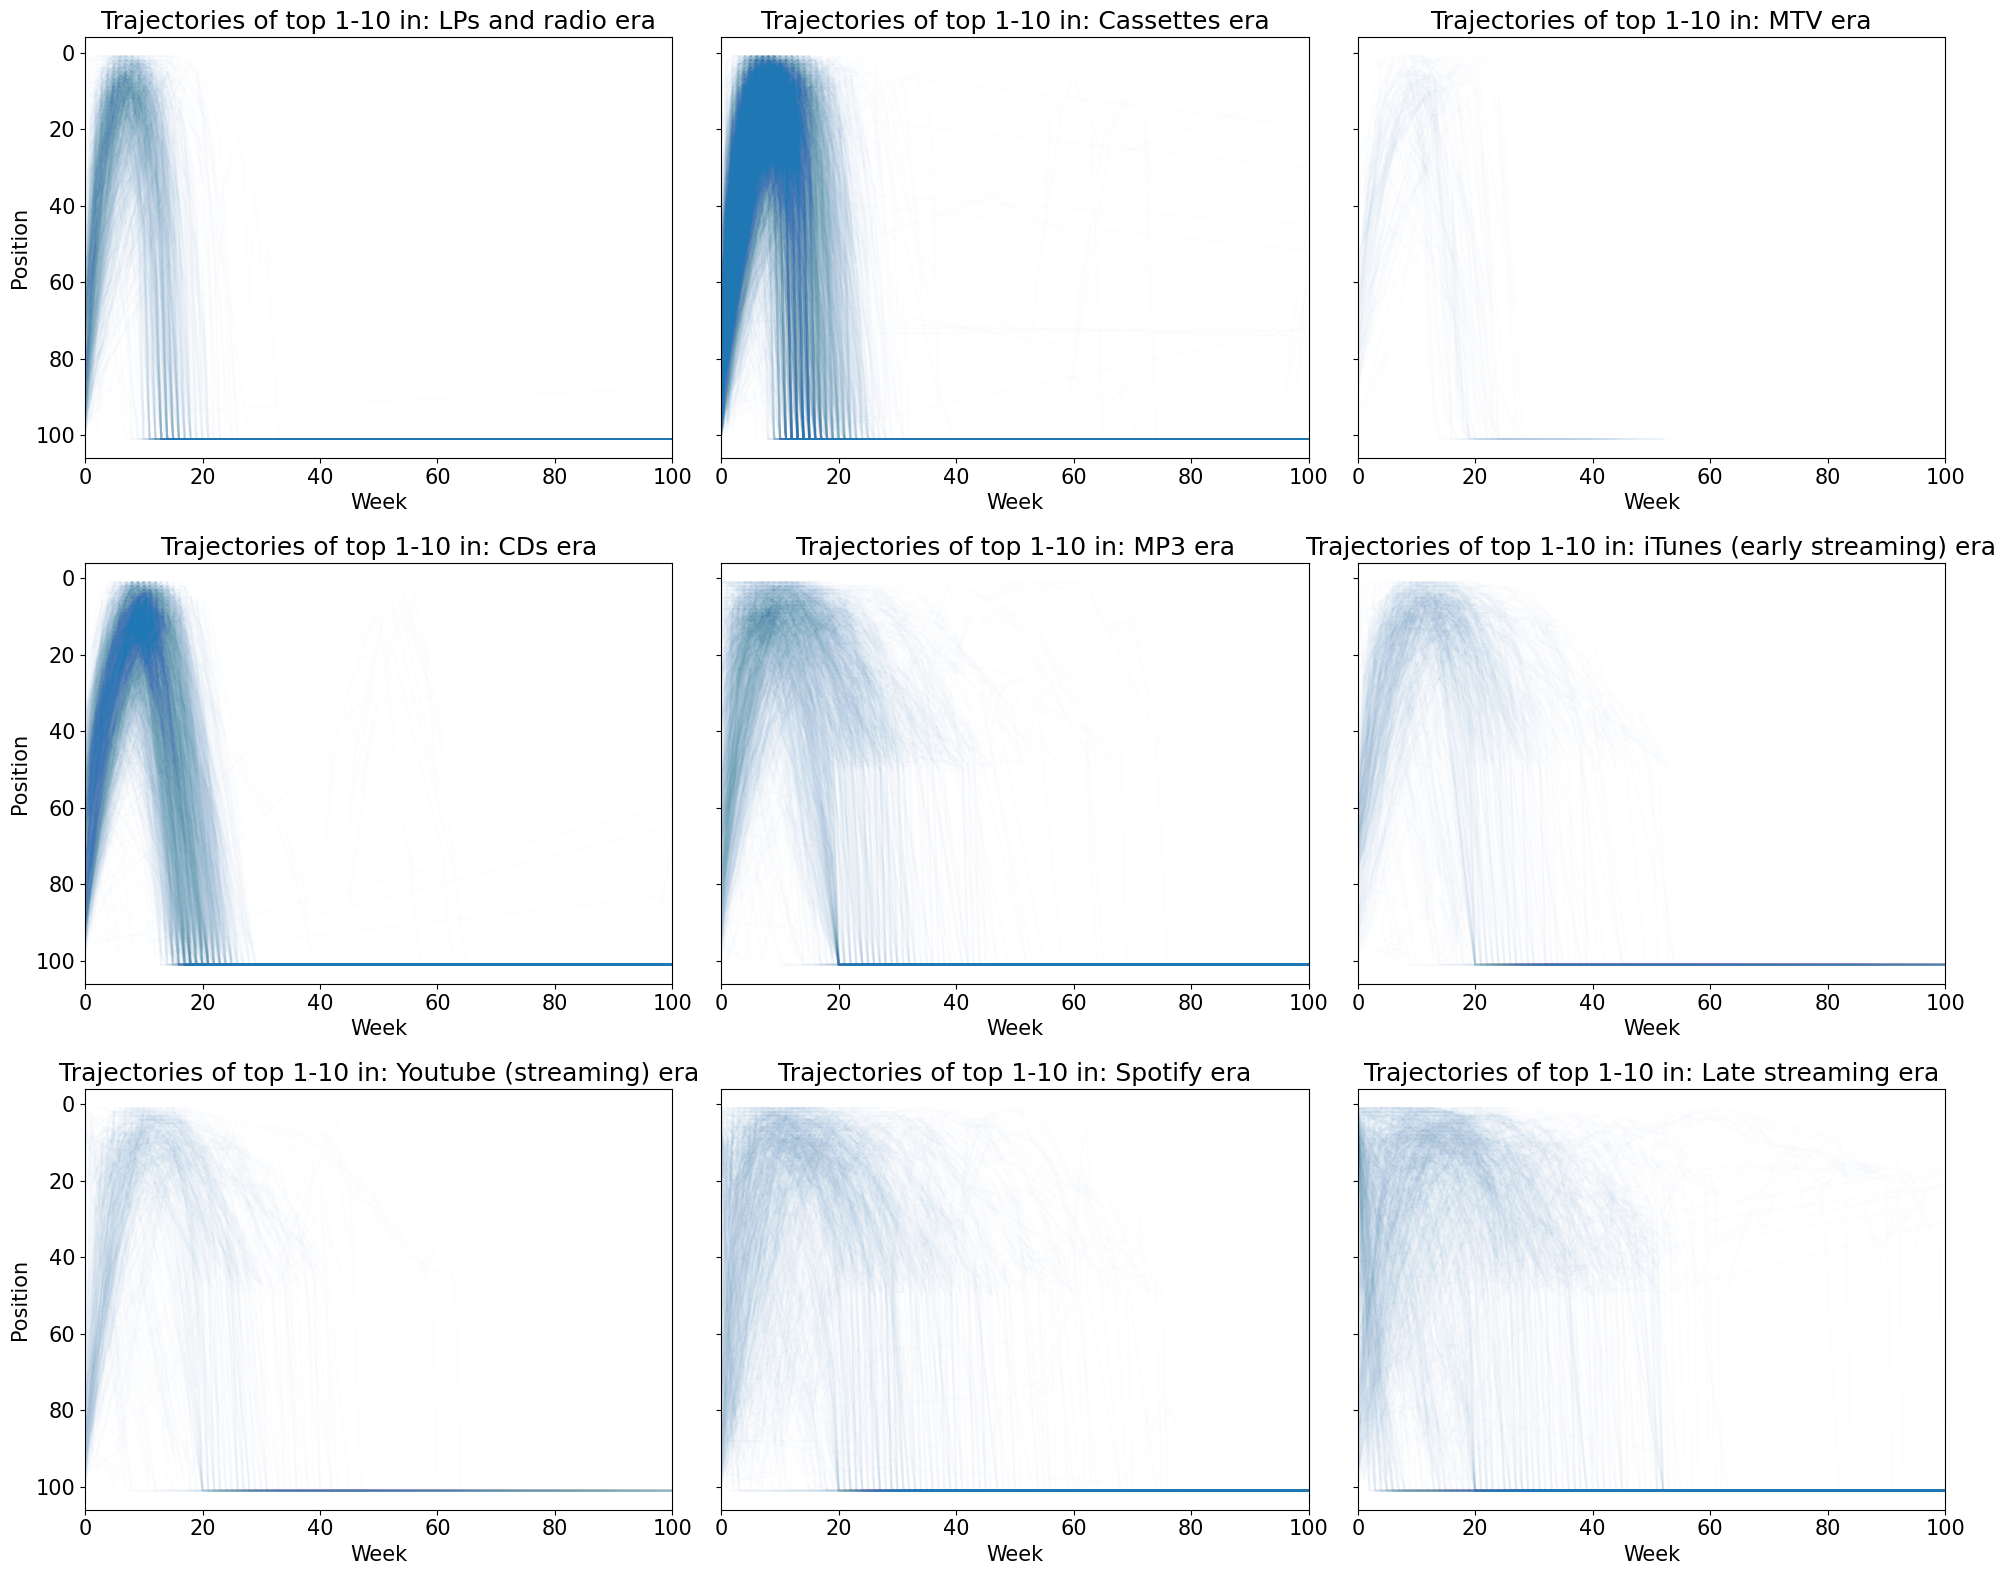

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for era in tqdm(eras):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks["era"] == era][["artist", "song_name", "first_day_of_the_week", "top_position", "position",
            "first_week", "era"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[billboard_hot_100["era"] != era][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = all_songs_in_decade[(all_songs_in_decade["top_position"] <= 10) &\
        (all_songs_in_decade["top_position"] > 0)][["artist", "song_name"]]

    # take songs only from this decade
    top_10_positions_in_decade = top_10_positions_in_decade[~(top_10_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
        top_10_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]

    # take all positions of the songs
    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
        billboard_100_with_empty_weeks[["artist", "song_name",
            "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

    min_first_week = top_10_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

    top_10_positions_in_decade["first_day_of_the_week"] = top_10_positions_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)
    top_10_positions_in_decade.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.01,
        color="C0")
    # axes[row_i, col_i].plot(top_x_positions_in_decade.groupby("first_day_of_the_week")["position"].mean(),
    #     marker='o', label=f"Top {top_position - 9}-{top_position}")

    axes[row_i, col_i].set_title(f"Trajectories of top 1-10 in: {era}")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim(0, 100)

    col_i += 1
    if col_i == 3:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
#plt.savefig("figures/average_position_change_per_top_position_decades.pdf", format="pdf")
plt.show()